In [1]:
#Packages
import arcpy
import psycopg2

### Create a polygon using arcpy geometry primitives and convert to WKT:

In [2]:
out_path= r'C:\Mac\Home\Documents\ArcGIS\Projects\GIS5572\Lab1_2\Lab1_2.gdb'
out_name= 'polygon_fc'
arcpy.management.CreateFeatureclass(out_path, out_name)

<Result 'C:\\Mac\\Home\\Documents\\ArcGIS\\Projects\\GIS5572\\Lab1_2\\Lab1_2.gdb\\polygon_fc'>

In [4]:
# Set Polygon Info
sr = arcpy.SpatialReference(4326)
feature_info = [[[1, 2], [2, 4], [3, 7]],[[6, 8], [5, 7], [7, 2], [9, 5]]]
features = []

In [5]:
# Create Geometry
for feature in feature_info:
    array = arcpy.Array([arcpy.Point(*coords) for coords in feature])
    array.append(array[0])
    
    polygon = arcpy.Polygon(array, sr)
    features.append(polygon)

In [6]:
# Add Geometry to Feature Class
with arcpy.da.InsertCursor('polygon_fc', ['SHAPE@']) as cursor:
    cursor.insertRow([polygon])

In [7]:
# Select Polygon
cursor = arcpy.da.SearchCursor('polygon_fc', "SHAPE@")
for element in cursor:
    x= element
    break

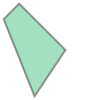

In [8]:
# Visualize Polygon
geom= x[0]
geom

In [9]:
wkt=polygon.WKT

### Use psycopg2to import the polygon to PostGIS database on  VM on Google Cloud running Linux Ubuntu

In [14]:
# Connect to db -change user/pass to run
conn_params = {
    "host": "35.202.29.226", 
    "database": "lab1-2",
    "user": "user",
    "password": "password", 
    "port": "5432"
}

conn = psycopg2.connect(**conn_params)
cursor = conn.cursor()

In [11]:
# SQL command to create table
create_table_query = """
    CREATE TABLE polygon (
        id SERIAL PRIMARY KEY,
        geom GEOMETRY(MULTIPOLYGON, 4326)
    );
"""

# Execute query
cursor.execute(create_table_query)
conn.commit()
print("Table 'polygon' created successfully.")



Table 'polygon' created successfully.


In [15]:
# Insert the polygon into PostgreSQL
insert_query = """
    INSERT INTO polygon (geom)
    VALUES (ST_GeomFromText(%s, 4326));
"""
cursor.execute(insert_query, (wkt,))
conn.commit()

# Step 5: Verify the insertion
cursor.execute("SELECT id, ST_AsText(geom) FROM polygon;")
rows = cursor.fetchall()
for row in rows:
    print(f"ID: {row[0]}, Geometry: {row[1]}")

# Step 6: Close the connection
cursor.close()
conn.close()

ID: 1, Geometry: MULTIPOLYGON(((6 8,5 7,7 2,9 5,6 8)))
ID: 2, Geometry: MULTIPOLYGON(((6 8,5 7,7 2,9 5,6 8)))
